In [215]:
import nltk
import numpy as np
import pandas as pd
import sklearn 
import pickle
import re
import urllib.request
import os
import tarfile
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import model_selection
from sklearn import svm
from matplotlib import pyplot as plt

## Download dataset

In [171]:
enron_url = 'http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/preprocessed/'
enron_files_train = ['enron1.tar.gz','enron2.tar.gz']
enron_files_test = ['enron4.tar.gz']

downloads = 'C:\\Users\\Krishna\\Downloads'
enron_dir = os.path.join(downloads, 'Enron_dataset')

if not os.path.exists(enron_dir):
    os.makedirs(enron_dir)
for file in enron_files_train:
    path = os.path.join(enron_dir, file)
    if not os.path.exists(path):
        urllib.request.urlretrieve(enron_url + file, path) 
    print("Downloaded "+file)
    
for file in enron_files_test:
    path = os.path.join(enron_dir, file)
    if not os.path.exists(path):
        urllib.request.urlretrieve(enron_url + file, path) 
    print("Downloaded "+file)

Downloaded enron1.tar.gz
Downloaded enron2.tar.gz
Downloaded enron4.tar.gz


## Extracting

In [224]:
emails_df_test = pd.DataFrame({'message': [], 'class': []})
for file in enron_files_test:
    fname = os.path.join(enron_dir,file)
    rows = []
    tfile = tarfile.open(fname, 'r:gz')
    for member in tfile.getmembers():
        if 'ham' in member.name:
            f = tfile.extractfile(member)
            if f is not None:
                row = f.read()
                rows.append({'message': row, 'class': 'ham'})
        if 'spam' in member.name:
            f = tfile.extractfile(member)
            if f is not None:
                row = f.read()
                rows.append({'message': row, 'class': 'spam'})
    tfile.close()
    emails_df_test = pd.concat([emails_df_test,pd.DataFrame(rows)])
emails_df_test.to_pickle(enron_dir + "/emails_test.pickle")

In [225]:
# Bytes to string
if type(emails_df_test['message'][0]) == bytes:
    emails_df_test['message'] = emails_df_test['message'].apply(lambda x: x.decode('latin-1'))
    
# Map 'spam' to 1 and 'ham' to 0.
emails_df_test['class'] = emails_df_test['class'].map({'spam':1, 'ham':0})

In [226]:
emails_df_test['message']

0       Subject: re : quasi\r\ngood morning ,\r\ni ' d...
1       Subject: enrononline desk to desk id and passw...
2       Subject: david gray\r\nbill ,\r\nis this the d...
3       Subject: re : monday blues\r\ngood morning . i...
4       Subject: monday blues\r\nbill ,\r\ni am having...
                              ...                        
5995    Subject: re : v with you phara maceutical\r\nu...
5996    Subject: check me out !\r\n61 bb\r\nhey derm\r...
5997    Subject: do you wish for a more active sex lif...
5998    Subject: why didnt you say hi\r\nthere is this...
5999    Subject: \r\nhtml\r\nbody\r\nb\r\npwhy not tak...
Name: message, Length: 6000, dtype: object

In [238]:
emails_df_train = pd.DataFrame({'message':[], 'class':[]})
rows = []
for file in enron_files_train:
    #emails_df = pd.DataFrame({'message': [], 'class': []})
    fname = os.path.join(enron_dir,file)
    tfile = tarfile.open(fname, 'r:gz')
    for member in tfile.getmembers():
        if 'ham' in member.name:
            f = tfile.extractfile(member)
            if f is not None:
                row = f.read()
                rows.append({'message': row, 'class': 'ham'})
        if 'spam' in member.name:
            f = tfile.extractfile(member)
            if f is not None:
                row = f.read()
                rows.append({'message': row, 'class': 'spam'})
    tfile.close()

emails_df_train = pd.concat([emails_df_train,pd.DataFrame(rows,index=None)])
emails_df_train.to_pickle(enron_dir + "/emails_train.pickle")

In [239]:
# Bytes to string
if type(emails_df_train['message'][0]) == bytes:
    emails_df_train['message'] = emails_df_train['message'].apply(lambda x: x.decode('latin-1'))
    
# Map 'spam' to 1 and 'ham' to 0.
emails_df_train['class'] = emails_df_train['class'].map({'spam':1, 'ham':0})

## Preprocessing

In [237]:
from string import punctuation

def preprocess_mails(email):
    
    email = email.lower()
    
    email = email.replace('\r\n', ' ')
    email = email.translate(str.maketrans("", "", punctuation))
    
    email = re.sub('[$]+', 'dollar', email)
    email = re.sub('Rs|[₹]+', 'rupees', email)
    email = re.sub('(http|https)\S+', 'url', email)
    email = re.sub('[a-z]+@[a-z]+', 'emailid', email)
    email = re.sub('[0-9]+', '', email)
    
    email = " ".join(email.split())
    
    return email

In [21]:
from nltk.stem import WordNetLemmatizer

def lemmatize_mails(email_df):
    
    output = []
    emails = email_df['message'].tolist()
    for email in emails:
        
        email = preprocess_mails(email)

        lemmatizer = WordNetLemmatizer()
        lemmatized = []
        tokens = email.split()

        for word in tokens:
            lemmatized.append(lemmatizer.lemmatize(word))

        output.append(" ".join(lemmatized))
    return output

## Stop word removal

In [181]:
def feature_extraction(emails):
    
    tfidf = TfidfVectorizer()
    tfidf.fit(emails)

    df_idf = pd.DataFrame(tfidf.idf_, index = tfidf.get_feature_names(),columns=["idf"]) 
    orderedWords = df_idf.sort_values(by=['idf'])  

    print("Extracting and removing Stop-Words")
    stopwords = [orderedWords['idf'].index[i] for i in range(40)]
    print(stopwords)

    number_of_features = 4000

    CV = CountVectorizer(stop_words = stopwords, max_features = number_of_features)
    term_frequency_vector = CV.fit_transform(emails)
    print(term_frequency_vector.shape)
    
    Top_features = term_frequency_vector.toarray()
    
    return Top_features,CV

## Naive Bayes

In [71]:
def NB(X_train, y_train, X_test):
    
    y_train = np.array(y_train)
    spam_ind = np.where(y_train == 1)[0]
    ham_ind = np.where(y_train == 0)[0]
    tot = len(y_train)
    spam = len(spam_ind)
    ham = len(ham_ind)
    p_spam = spam/tot
    #print(p_spam)
    p_ham = ham/tot
    #print(p_ham)

    spam_mails = X_train[spam_ind]
    ham_mails = X_train[ham_ind]
    
    r = np.ones((1, X_train.shape[1]))
    spam_mails = np.append(spam_mails, r , axis=0)
    ham_mails = np.append(ham_mails, r , axis=0)
    
    spam_words = np.zeros(X_train.shape[1])
    ham_words = np.zeros(X_train.shape[1])
    

    for mail in spam_mails:
        spam_words = spam_words + mail
    for mail in ham_mails:
        ham_words = ham_words + mail

    tot_spam_words = np.sum(spam_words)
    tot_ham_words = np.sum(ham_words)

    p_spam_word = []
    p_ham_word = []

    for i in range(spam_mails.shape[1]):
        s = 0
        for j in range(spam_mails.shape[0]):
            s = s + spam_mails[j][i]
        s = s/tot_spam_words
        p_spam_word.append(s)

    for i in range(ham_mails.shape[1]):
        s = 0
        for j in range(ham_mails.shape[0]):
            s = s + ham_mails[j][i]
        s = s/tot_ham_words
        p_ham_word.append(s)

    y_pred = []

    for i in range(X_test.shape[0]):
        p_test_spam = 0
        p_test_ham = 0
        for j in range(X_test.shape[1]):
            if(X_test[i,j]!=0):
                
                p_test_spam += np.log(p_spam_word[j])

                p_test_ham += np.log(p_ham_word[j])
            
        p_test_spam += np.log(p_spam)
        p_test_ham += np.log(p_ham)
        if(p_test_ham > p_test_spam):
            y_pred.append(0)
        else:
            y_pred.append(1)

    return y_pred

In [256]:
X_train = lemmatize_mails(emails_df_train)
X_test = lemmatize_mails(emails_df_test)
X_train_vector = feature_extraction(emails_df_train['message'])[0]
CV = feature_extraction(emails_df_train['message'])[1]
X_test_vector = CV.transform(emails_df_test['message'])
X_test_vector = X_test_vector.toarray()
y_train = emails_df_train['class'].to_list()

Extracting and removing Stop-Words
['subject', 'to', 'the', 'for', 'and', 'you', 'of', 'on', 'is', 'in', 'this', 'have', 'be', 'with', 'your', 'we', 'from', 'that', 'please', 'will', 'at', 'are', 'if', 'it', 'by', 'enron', 'as', 'me', 'not', 'or', 'am', 'cc', 'can', '2000', 'thanks', 'our', 're', 'com', 'any', 'know']
(11029, 4000)
Extracting and removing Stop-Words
['subject', 'to', 'the', 'for', 'and', 'you', 'of', 'on', 'is', 'in', 'this', 'have', 'be', 'with', 'your', 'we', 'from', 'that', 'please', 'will', 'at', 'are', 'if', 'it', 'by', 'enron', 'as', 'me', 'not', 'or', 'am', 'cc', 'can', '2000', 'thanks', 'our', 're', 'com', 'any', 'know']
(11029, 4000)


In [241]:
y_pred = NB(X_train_vector, y_train, X_test_vector)

In [242]:
def accuracy(orig, pred):
    return (1 - (np.sum(abs(orig-pred)))/len(pred))*100
accuracy(np.array(emails_df_test['class']),np.array(y_pred))

94.88333333333333

In [243]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(X_train_vector, y_train)
print(accuracy(np.array(emails_df_test['class']), clf.predict(X_test_vector)))

96.46666666666667


## SVM

In [245]:
acc = []
for c in range(1,10):
    model = svm.SVC(C=c)
    model.fit(X_train_vector, y_train)
    acc.append(accuracy(np.array(emails_df_test['class']), model.predict(X_test_vector)))

Max accuracy obtained for C = 4


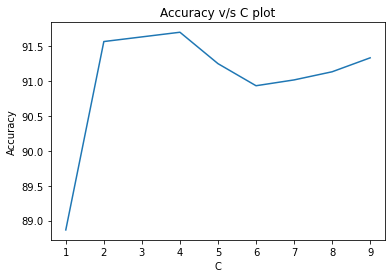

In [266]:
crange = list(range(1,10))
plt.plot(crange, acc)
plt.title('Accuracy v/s C plot')
plt.xlabel("C")
plt.ylabel('Accuracy')
print(f"Max accuracy obtained for C = {crange[acc.index(max(acc))]}")

In [249]:
model = svm.SVC(C=4)
model.fit(X_train_vector, y_train)
print(accuracy(np.array(emails_df_test['class']), model.predict(X_test_vector)))

91.7


## Testing 
Run all the previous cells and then run the following to get predictions

In [262]:
import os
import glob

def test_mails(mod = 'NB'):
    
    root = os.getcwd() 
    test_dir = os.path.join(root,'test') # add the test mails in the test folder
    
    row = []
    if not os.path.exists(test_dir):
        os.makedirs(test_dir) # add the test mails in the test folder
    for file in os.listdir(test_dir):
        path = os.path.join(test_dir,file)
        f = open(path,'r')
        test_mail = f.read()
        row.append(test_mail)
    
    test_mails_df = pd.DataFrame({'message':row})
    test_mail_lemmatize = lemmatize_mails(test_mails_df)
    feature_vec_test = CV.transform(test_mail_lemmatize)
    
    ypred = NB(X_train_vector, y_train, feature_vec_test)
    return ypred

In [261]:
y = test_mails('NB')

In [263]:
print(y)

[1, 0]
